In [3]:
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal
from scipy.linalg import cho_factor, cho_solve

# 1.Implementation of the method in project

In [4]:
'''
This is a matrix A in 2.1 and 3.1
'''
def action_matrix(n):
    
    #initialize the matrix with n-1 rows and n-1 columns
    
    matrix = np.zeros((n-1,n-1)) 
    
    #discretization
    
    h = 1/n
    
    for i in range(n-1):
        matrix[i,i] = -2
        if i > 0:
            matrix[i,i-1] = 1
        if i < n - 2:
            matrix[i, i+1] = 1
    
    matrix = (-1)* matrix *(1/(h**2))
    
    return matrix

def A_labda(A, labda):
    n = A.shape[0]
    return A + labda * np.identity(n)
    

def solve_equation(A, labda):
    '''
    This function gives an accurate numerical solution for heat equation at time labda
    it uses the equation 2.1
    input:
    A: matrix A
    labda: time labda
    
    output: accurate result, a vector with (n-1) entries
    
    '''
    n = A.shape[0]
    e_1 = np.array([1] + [0]*(n-1))
    A_labda = A + labda * np.identity(n)
    c, low = cho_factor(A_labda)
    result = cho_solve((c, low), e_1)
    return result

def vector_d(A, k, l_bound, u_bound):
    '''
    input:
    A: matrix A
    k: discretion of interval [eps, u_bound]
    eps: lower bound
    u_bound: upper bound
    
    output: left side of the equation (3.1), vector d with k components
    
    '''
    n = A.shape[0]
    h_ = (u_bound - l_bound)/k
    d_vector = np.array([solve_equation(A, (l_bound + (i+1) * h_ ))[0] for i in range(k)])        
    return d_vector

# 1.1 Basic Setting

In this case, I am assuming that I discretize $\lambda$ on interval $[l_u, u_b]$
<br>
The part below is mainly about Part 2.
Solving the $(A + \lambda I)u = e_1$ <br>
And get vector $(d(\lambda_1),.... d(\lambda_k))$ <br>

Note k is the discretion of $\lambda$ on its interval

For the part below I construct: <br>
matrix $V_k = [(A + \lambda_1 I)^{-1} e_1,..., (A + \lambda_k I)^{-1} e_1]$ <br>
matrix $M = V_k^T V_k$ <br>
matrix $S = V_k^T A V $

In [5]:
def V_matrix(A, k, l_bound, u_bound):
    '''
    This function gives the matrix V
    '''
    n = A.shape[0]
    V = np.zeros([n, k])
    h_ = (u_bound - l_bound)/k
    for i in range(k):
        A_lambda = A + (l_bound + (i+1) * h_) * np.identity(n)
        V[:, i] = np.linalg.inv(A_lambda)[:, 0]
    return V

def M_matrix(V):
    VT = np.transpose(V)
    return np.matmul(VT, V)


def S_matrix(V, A):
    VT = np.transpose(V)
    return np.matmul(VT, np.matmul(A, V))
    

For the part below we want to solve the equation 3.1:<br>

For equation 3.1, given any $\lambda \in [\lambda_{min}, \lambda_{max}]$: we can approximate the vector $u(\dot, \lambda)$ which has (n-1) entries:<br>
$(S + \lambda M) w_k = (d(\lambda_1),.... d(\lambda_k))^*$<br>
$u \approx V_k w_k$

# 1.2 projection framework

For this part I construct matrix $Z$ which is a controller:
which is a matrix whose columns are eigenvectors of $M$ corresponding to eigenvalue $\mu_i > \epsilon$:<br>
I implement this matrix with SVD since $M$ is positive definite. Within the svd algorithm, eigenvalue will be arranged in descending order

In [6]:
def Z_matrix(M, eps):
    '''
    M: matrix M
    eps: \epsilon in the last part
    '''
    U, sigma, Vh = np.linalg.svd(M, full_matrices=True, compute_uv=True, hermitian=True)
    length = len(sigma)
    for i in range(length):
        if sigma[i] < eps:
             return U[:, :i]
    return U

For this part, I will create a modified version of approximation of $u$ with $Z$:<br>
$(Z^* S Z + \lambda Z^* M Z) w_k = Z^* (d(\lambda_1),.... d(\lambda_k))^*$. <br>
$u = V Z w_k$

In [8]:
def appro_solve_controller(A, k, l_bound, u_bound, labda, eps, noise, noise_vector, fix_vector):
    '''
    noise:
    if the noise level is specified
    it generated the different d_vector for different labda
    
    noise_vector: 
    the d_vector with noise we want to input.
    For different labda, the noise vector is the same
    
    fix_vector: 
    bool value check if we want to input the d_vector we predetermined
    '''
    n = A.shape[0]
    V = V_matrix(A, k, l_bound, u_bound)
    M = M_matrix(V)
    S = S_matrix(V, A)
    Z = Z_matrix(M, eps)
    # I am not sure if this is a correct way
    if noise:
        d = vector_d(A, k, l_bound, u_bound)
        for i in range(k):
            s = np.random.uniform(-1,0,1)
            d[i] = d[i] * (1 + noise * s) 
    else:
        d = vector_d(A, k, l_bound, u_bound)
    if fix_vector:
        d = noise_vector
    ZSZ = np.matmul(np.transpose(Z), np.matmul(S, Z))
    ZMZ = np.matmul(np.transpose(Z), np.matmul(M, Z))
    Zd = np.matmul(np.transpose(Z), d)
    w = np.linalg.solve((ZSZ + labda * ZMZ), Zd)
    appro_result = np.matmul(V, np.matmul(Z, w))
    return appro_result

Error Function

In [9]:
def log_error_test(A, k, m, l_bound, u_bound, eps, noise, noise_vector, fix_vector):
    #k is the discretion we use for getting M and S
    #m is the discretion for our test
    #So I am using the testing data generated from the new discretization
    '''
    noise:
    if the noise level is specified
    it generated the different d_vector for different labda
    
    noise_vector: 
    the d_vector with noise we want to input.
    For different labda, the noise vector is the same
    
    fix_vector: 
    bool value check if we want to input the d_vector we predetermined
    '''
    h_ = (u_bound - l_bound)/m
    error_vector = [np.linalg.norm(appro_solve_controller(A, k, l_bound, u_bound, 
                                                          l_bound + h_ * (i+1), eps, noise, noise_vector, fix_vector)
                                  - solve_equation(A, l_bound + h_ * (i+1)))/np.linalg.norm(solve_equation(A, l_bound + h_ * (i+1))) for i in range(m)]
    log_error = [Decimal(e).ln() for e in error_vector]
    return log_error

# 1.3 Loewner's Framework

In [10]:
def deri_d(A, d_vector, k, l_bound, u_bound):
    '''
    input:
    A: matrix A
    k: discretion of interval [eps, u_bound]
    eps: lower bound
    u_bound: upper bound
    
    output: left side of the equation (3.1), vector deri_d is the derivative of d with k compoenents
    
    '''
    n = A.shape[0]
    h_ = (u_bound - l_bound)/k
    deri_vector = np.array([-np.dot(solve_equation(A, l_bound + (i+1) * h_), solve_equation(A, l_bound + (i+1) * h_)) for i in range(k)])
    deri_labda_vector = np.array([(d_vector[i] + (l_bound + (i+1) * h_)* deri_vector[i]) for i in range(k)])
    return deri_vector, deri_labda_vector

def M_Matrix_L(deri_vector, d_vector, k, l_bound, u_bound, noise):
    h_ = (u_bound - l_bound)/k
    M = np.zeros([k, k])
    for i in range(k-1):
        for j in range(i+1, k):
            M[i, j] = -(d_vector[i] - d_vector[j])/((i-j)*h_)
            M[j, i] = -(d_vector[i] - d_vector[j])/((i-j)*h_)

    for i in range(k):
        M[i, i] = -deri_vector[i]
    return M

def S_Matrix_L(deri_labda_vector, d_vector, k, l_bound, u_bound, noise):
    h_ = (u_bound - l_bound)/k
    S = np.zeros([k, k])
    for i in range(k-1):
        for j in range(i+1, k):
            S[i, j] = ((l_bound + (i+1) * h_) * d_vector[i] - (l_bound + (j+1) * h_) * d_vector[j])/((i-j)*h_)
            S[j, i] = ((l_bound + (i+1) * h_) * d_vector[i] - (l_bound + (j+1) * h_) * d_vector[j])/((i-j)*h_)

    for i in range(k):
        S[i, i] = deri_labda_vector[i]
    return S


def appro_solve_controller_L(A, k, l_bound, u_bound, labda, eps, noise, noise_vector, fix_vector):
    '''
    noise:
    if the noise level is specified
    it generated the different d_vector for different labda
    
    noise_vector: 
    the d_vector with noise we want to input.
    For different labda, the noise vector is the same
    
    fix_vector: 
    bool value check if we want to input the d_vector we predetermined
    '''
    
    n = A.shape[0]
    V = V_matrix(A, k, l_bound, u_bound)
    if noise:
        d = vector_d(A, k, l_bound, u_bound)
        for i in range(k):
            s = np.random.uniform(-1,0,1)
            d[i] = d[i] * (1 + noise * s) 
    else:
        d = vector_d(A, k, l_bound, u_bound)
    if fix_vector:
        d = noise_vector
    deri_vector, deri_labda_vector = deri_d(A, d, k, l_bound, u_bound)
    M = M_Matrix_L(deri_vector, d, k, l_bound, u_bound, noise)
    S = S_Matrix_L(deri_labda_vector, d, k, l_bound, u_bound, noise)
    Z = Z_matrix(M, eps)
    # I am not sure if this is a correct way
    ZSZ = np.matmul(np.transpose(Z), np.matmul(S, Z))
    ZMZ = np.matmul(np.transpose(Z), np.matmul(M, Z))
    Zd = np.matmul(np.transpose(Z), d)
    w = np.linalg.solve((ZSZ + labda * ZMZ), Zd)
    appro_result = np.matmul(V, np.matmul(Z, w))
    return appro_result

In [11]:
def log_error_L_test(A, k, m, l_bound, u_bound, eps, noise, noise_vector, fix_vector):
    #k is the discretion we use for getting M and S
    #m is the discretion for our test
    #So I am using the testing data generated from the new discretization
    '''
    noise:
    if the noise level is specified
    it generated the different d_vector for different labda
    
    noise_vector: 
    the d_vector with noise we want to input.
    For different labda, the noise vector is the same
    
    fix_vector: 
    bool value check if we want to input the d_vector we predetermined
    '''
    h_ = (u_bound - l_bound)/m
    error_vector = [np.linalg.norm(appro_solve_controller_L(A, k, l_bound, u_bound, 
                                                          l_bound + h_ * (i+1), eps, noise, noise_vector, fix_vector)
                                  - solve_equation(A, l_bound + h_ * (i+1)))/np.linalg.norm(solve_equation(A, l_bound + h_ * (i+1))) for i in range(m)]
    log_error = [Decimal(e).ln() for e in error_vector]
    return log_error

In [12]:
plt.rcParams['figure.figsize'] = (8, 4)

# 2.Projection Framework

# 2.1Noiseless data case(Projection Framework)

For $n = 101$, $\lambda \in [60,300]$ <br>
Test matrix: A is 100 by 100 matrix <br>
Frequency: $k = 20, 60, 100$ <br>
Sample: $m = 80$<br>
$\epsilon = 0, 1e-24, 1e-20, 1e-18, 1e-16$, $1e-14$ <br>
Noiseless data. <br>
Range:$[60, 300]$. <br>
Sample: $80$

# 2.1.1 k = 20 case

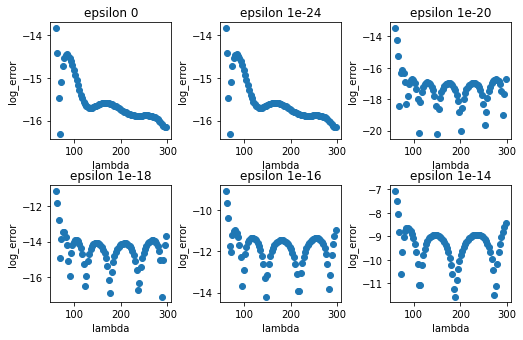

In [13]:
xx = np.arange(60, 300, 240/80)

log_error_0 = log_error_test(action_matrix(101), 20, 80, 60, 300, 0, None, None, False)
log_error_m24 = log_error_test(action_matrix(101), 20, 80, 60, 300, 1e-24, None, None, False)
log_error_m20 = log_error_test(action_matrix(101), 20, 80, 60, 300, 1e-20, None, None, False)
log_error_m18 = log_error_test(action_matrix(101), 20, 80, 60, 300, 1e-18, None, None, False)
log_error_m16 = log_error_test(action_matrix(101), 20, 80, 60, 300, 1e-16, None, None, False)
log_error_m14 = log_error_test(action_matrix(101), 20, 80, 60, 300, 1e-14, None, None, False)

fig, axs = plt.subplots(2, 3)
axs[0, 0].scatter(xx, log_error_0)
axs[0, 0].set_title('epsilon 0')
axs[0, 1].scatter(xx, log_error_m24)
axs[0, 1].set_title('epsilon 1e-24')
axs[0, 2].scatter(xx, log_error_m20)
axs[0, 2].set_title('epsilon 1e-20')
axs[1, 0].scatter(xx, log_error_m18)
axs[1, 0].set_title('epsilon 1e-18')
axs[1, 1].scatter(xx, log_error_m16)
axs[1, 1].set_title('epsilon 1e-16')
axs[1, 2].scatter(xx, log_error_m14)
axs[1, 2].set_title('epsilon 1e-14')

for ax in axs.flat:
    ax.set(xlabel='lambda', ylabel='log_error')

plt.subplots_adjust(left=0.1,
                    bottom=0.03, 
                    right=0.9, 
                    top=1.0, 
                    wspace=0.4, 
                    hspace=0.4)


# 2.1.2 k = 60 case

Frequency = 60, sampling = 80

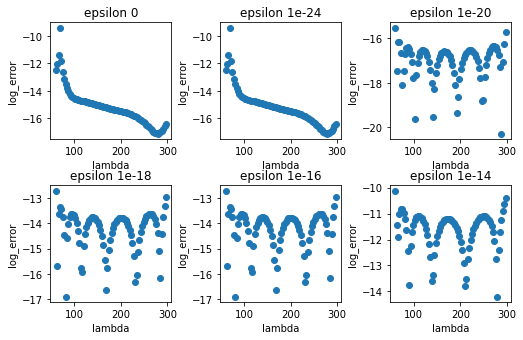

In [168]:
xx = np.arange(60, 300, 240/80)

log_error_0 = log_error_test(action_matrix(101), 60, 80, 60, 300, 0, None, None, False)
log_error_m24 = log_error_test(action_matrix(101), 60, 80, 60, 300, 1e-24, None, None, False)
log_error_m20 = log_error_test(action_matrix(101), 60, 80, 60, 300, 1e-20, None, None, False)
log_error_m18 = log_error_test(action_matrix(101), 60, 80, 60, 300, 1e-18, None, None, False)
log_error_m16 = log_error_test(action_matrix(101), 60, 80, 60, 300, 1e-16, None, None, False)
log_error_m14 = log_error_test(action_matrix(101), 60, 80, 60, 300, 1e-14, None, None, False)

fig, axs = plt.subplots(2, 3)
axs[0, 0].scatter(xx, log_error_0)
axs[0, 0].set_title('epsilon 0')
axs[0, 1].scatter(xx, log_error_m24)
axs[0, 1].set_title('epsilon 1e-24')
axs[0, 2].scatter(xx, log_error_m20)
axs[0, 2].set_title('epsilon 1e-20')
axs[1, 0].scatter(xx, log_error_m18)
axs[1, 0].set_title('epsilon 1e-18')
axs[1, 1].scatter(xx, log_error_m16)
axs[1, 1].set_title('epsilon 1e-16')
axs[1, 2].scatter(xx, log_error_m14)
axs[1, 2].set_title('epsilon 1e-14')



for ax in axs.flat:
    ax.set(xlabel='lambda', ylabel='log_error')

plt.subplots_adjust(left=0.1,
                    bottom=0.03, 
                    right=0.9, 
                    top=1.0, 
                    wspace=0.4, 
                    hspace=0.4)


# 2.1.3 k = 100 case

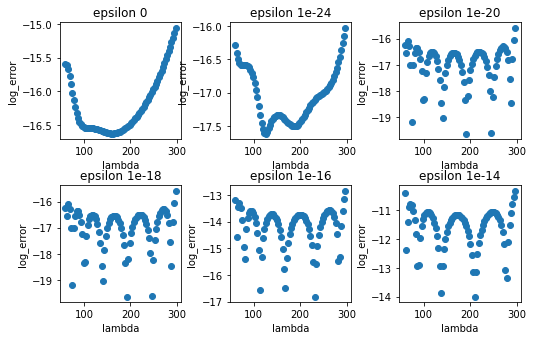

In [170]:
log_error_0 = log_error_test(action_matrix(101), 100, 80, 60, 300, 0, None, None, False)
log_error_m24 = log_error_test(action_matrix(101), 100, 80, 60, 300, 1e-24, None, None, False)
log_error_m20 = log_error_test(action_matrix(101), 100, 80, 60, 300, 1e-20, None, None, False)
log_error_m18 = log_error_test(action_matrix(101), 100, 80, 60, 300, 1e-18, None, None, False)
log_error_m16 = log_error_test(action_matrix(101), 100, 80, 60, 300, 1e-16, None, None, False)
log_error_m14 = log_error_test(action_matrix(101), 100, 80, 60, 300, 1e-14, None, None, False)

fig, axs = plt.subplots(2, 3)
axs[0, 0].scatter(xx, log_error_0)
axs[0, 0].set_title('epsilon 0')
axs[0, 1].scatter(xx, log_error_m24)
axs[0, 1].set_title('epsilon 1e-24')
axs[0, 2].scatter(xx, log_error_m20)
axs[0, 2].set_title('epsilon 1e-20')
axs[1, 0].scatter(xx, log_error_m18)
axs[1, 0].set_title('epsilon 1e-18')
axs[1, 1].scatter(xx, log_error_m16)
axs[1, 1].set_title('epsilon 1e-16')
axs[1, 2].scatter(xx, log_error_m14)
axs[1, 2].set_title('epsilon 1e-14')

for ax in axs.flat:
    ax.set(xlabel='lambda', ylabel='log_error')

plt.subplots_adjust(left=0.1,
                    bottom=0.03, 
                    right=0.9, 
                    top=1.0, 
                    wspace=0.4, 
                    hspace=0.4)


Conclusion: <br>
Fix $\epsilon$, the greater $k$, the less log error.<br>
Fix $\epsilon = 1e-18$, when $k = 100$, it has better result then $k = 60$ and $k = 20$.<br>
Fix $k$, the greater epsilon, the less log error until $\epsilon = 1e - 20$.<br>
My guess, as $k$ becomes greater, the turning point of the change of log error will be greater.<br>
Supplement: turning points means that as the increase of $\epsilon$ the log error will decrease first then after the turning point, the log error will increase.

# 2.2 Data with noise(projection framework)

# 2.2.1 comparing data with noise and data without noise(k = 60 case)

Fix $\epsilon = 1e-20$

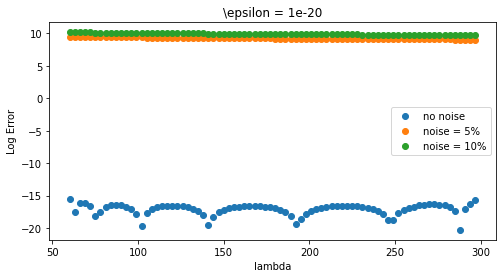

In [15]:
xxc = np.arange(60, 300, 240/80)

noise_vector_1 = vector_d(action_matrix(101), 60, 60, 300)
noise_vector_2 = vector_d(action_matrix(101), 60, 60, 300)


for i in range(60):
             s = np.random.uniform(-1,0,1)
             noise_vector_1[i] = noise_vector_1[i] * (1 + 0.05 * s)
             noise_vector_2[i] = noise_vector_2[i] * (1 + 0.1 * s)


         


log_error_0 = log_error_test(action_matrix(101), 60, 80, 60, 300, 1e-20, None, None, False)
log_error_noi05 = log_error_test(action_matrix(101), 60, 80, 60, 300, 1e-20, None, noise_vector_1, True)
log_error_noi1 = log_error_test(action_matrix(101), 60, 80, 60, 300, 1e-20, None, noise_vector_2, True)


plt.scatter(xxc, log_error_0, label = 'no noise')
plt.scatter(xxc, log_error_noi05, label = 'noise = 5%')
plt.scatter(xxc, log_error_noi1, label = 'noise = 10%')
plt.xlabel("lambda")
plt.ylabel("Log Error")
plt.title("\epsilon = 1e-20")
plt.legend()
plt.show()

Obviously, the greater the noise, the worse the result

# 2.2.2 k = 60, noise level 0.05, different epsilon.

$\epsilon = 0, 1e-24, 1e-20, 1e-18, 1e-16$, $1e-10$ <br>

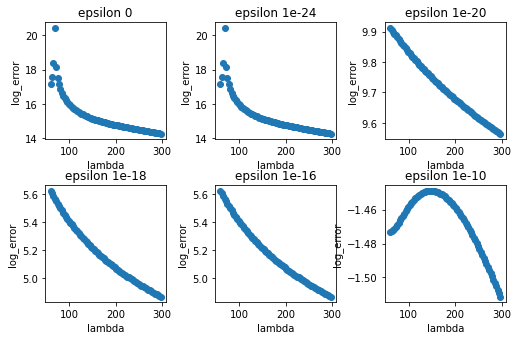

In [181]:
xx = np.arange(60, 300, 240/80)

log_error_0 = log_error_test(action_matrix(101), 60, 80, 60, 300, 0, None, noise_vector_1, True)
log_error_m24 = log_error_test(action_matrix(101), 60, 80, 60, 300, 1e-24, None, noise_vector_1, True)
log_error_m20 = log_error_test(action_matrix(101), 60, 80, 60, 300, 1e-20, None, noise_vector_1, True)
log_error_m18 = log_error_test(action_matrix(101), 60, 80, 60, 300, 1e-18, None, noise_vector_1, True)
log_error_m16 = log_error_test(action_matrix(101), 60, 80, 60, 300, 1e-16, None, noise_vector_1, True)
log_error_m10 = log_error_test(action_matrix(101), 60, 80, 60, 300, 1e-10, None, noise_vector_1, True)

fig, axs = plt.subplots(2, 3)
axs[0, 0].scatter(xx, log_error_0)
axs[0, 0].set_title('epsilon 0')
axs[0, 1].scatter(xx, log_error_m24)
axs[0, 1].set_title('epsilon 1e-24')
axs[0, 2].scatter(xx, log_error_m20)
axs[0, 2].set_title('epsilon 1e-20')
axs[1, 0].scatter(xx, log_error_m18)
axs[1, 0].set_title('epsilon 1e-18')
axs[1, 1].scatter(xx, log_error_m16)
axs[1, 1].set_title('epsilon 1e-16')
axs[1, 2].scatter(xx, log_error_m10)
axs[1, 2].set_title('epsilon 1e-10')



for ax in axs.flat:
    ax.set(xlabel='lambda', ylabel='log_error')

plt.subplots_adjust(left=0.1,
                    bottom=0.03, 
                    right=0.9, 
                    top=1.0, 
                    wspace=0.4, 
                    hspace=0.4)

With noise, the greater $\epsilon$, means the less log error.

# 2.2.2 k = 60, noise level 0.1, different epsilon.

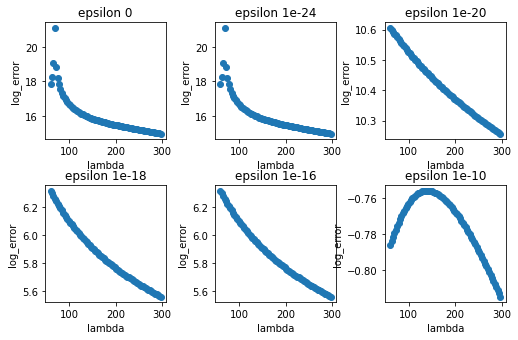

In [182]:
xx = np.arange(60, 300, 240/80)

log_error_0 = log_error_test(action_matrix(101), 60, 80, 60, 300, 0, None, noise_vector_2, True)
log_error_m24 = log_error_test(action_matrix(101), 60, 80, 60, 300, 1e-24, None, noise_vector_2, True)
log_error_m20 = log_error_test(action_matrix(101), 60, 80, 60, 300, 1e-20, None, noise_vector_2, True)
log_error_m18 = log_error_test(action_matrix(101), 60, 80, 60, 300, 1e-18, None, noise_vector_2, True)
log_error_m16 = log_error_test(action_matrix(101), 60, 80, 60, 300, 1e-16, None, noise_vector_2, True)
log_error_m10 = log_error_test(action_matrix(101), 60, 80, 60, 300, 1e-10, None, noise_vector_2, True)

fig, axs = plt.subplots(2, 3)
axs[0, 0].scatter(xx, log_error_0)
axs[0, 0].set_title('epsilon 0')
axs[0, 1].scatter(xx, log_error_m24)
axs[0, 1].set_title('epsilon 1e-24')
axs[0, 2].scatter(xx, log_error_m20)
axs[0, 2].set_title('epsilon 1e-20')
axs[1, 0].scatter(xx, log_error_m18)
axs[1, 0].set_title('epsilon 1e-18')
axs[1, 1].scatter(xx, log_error_m16)
axs[1, 1].set_title('epsilon 1e-16')
axs[1, 2].scatter(xx, log_error_m10)
axs[1, 2].set_title('epsilon 1e-10')



for ax in axs.flat:
    ax.set(xlabel='lambda', ylabel='log_error')

plt.subplots_adjust(left=0.1,
                    bottom=0.03, 
                    right=0.9, 
                    top=1.0, 
                    wspace=0.4, 
                    hspace=0.4)

With noise, greater $\epsilon$ would be better and it means that we need to truncate more vectors.

# 3.Lowner's Framework

# 3.1.Noiseless data

For $n = 101$, $\lambda \in [60,300]$ <br>
Test matrix: A is 100 by 100 matrix <br>
Frequency: $k = 20, 60, 100$ <br>
Sample: $m = 80$<br>
$\epsilon = 0, 1e-24, 1e-20, 1e-18, 1e-16$, $1e-14$ <br>
Noiseless data. <br>
Range:$[60, 300]$. <br>
Sample: $80$

# 3.1.1 k = 20

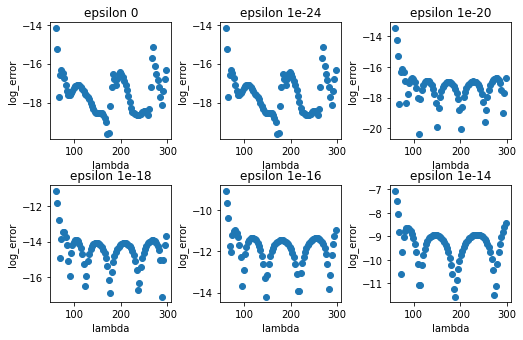

In [16]:
xx = np.arange(60, 300, 240/80)

log_error_0 = log_error_L_test(action_matrix(101), 20, 80, 60, 300, 0, None, None, False)
log_error_m24 = log_error_L_test(action_matrix(101), 20, 80, 60, 300, 1e-24, None, None, False)
log_error_m20 = log_error_L_test(action_matrix(101), 20, 80, 60, 300, 1e-20, None, None, False)
log_error_m18 = log_error_L_test(action_matrix(101), 20, 80, 60, 300, 1e-18, None, None, False)
log_error_m16 = log_error_L_test(action_matrix(101), 20, 80, 60, 300, 1e-16, None, None, False)
log_error_m14 = log_error_L_test(action_matrix(101), 20, 80, 60, 300, 1e-14, None, None, False)

fig, axs = plt.subplots(2, 3)
axs[0, 0].scatter(xx, log_error_0)
axs[0, 0].set_title('epsilon 0')
axs[0, 1].scatter(xx, log_error_m24)
axs[0, 1].set_title('epsilon 1e-24')
axs[0, 2].scatter(xx, log_error_m20)
axs[0, 2].set_title('epsilon 1e-20')
axs[1, 0].scatter(xx, log_error_m18)
axs[1, 0].set_title('epsilon 1e-18')
axs[1, 1].scatter(xx, log_error_m16)
axs[1, 1].set_title('epsilon 1e-16')
axs[1, 2].scatter(xx, log_error_m14)
axs[1, 2].set_title('epsilon 1e-14')

for ax in axs.flat:
    ax.set(xlabel='lambda', ylabel='log_error')

plt.subplots_adjust(left=0.1,
                    bottom=0.03, 
                    right=0.9, 
                    top=1.0, 
                    wspace=0.4, 
                    hspace=0.4)

# 3.1.1 k = 60

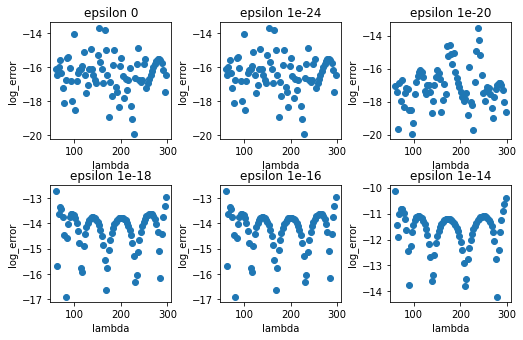

In [17]:
xx = np.arange(60, 300, 240/80)

log_error_0 = log_error_L_test(action_matrix(101), 60, 80, 60, 300, 0, None, None, False)
log_error_m24 = log_error_L_test(action_matrix(101), 60, 80, 60, 300, 1e-24, None, None, False)
log_error_m20 = log_error_L_test(action_matrix(101), 60, 80, 60, 300, 1e-20, None, None, False)
log_error_m18 = log_error_L_test(action_matrix(101), 60, 80, 60, 300, 1e-18, None, None, False)
log_error_m16 = log_error_L_test(action_matrix(101), 60, 80, 60, 300, 1e-16, None, None, False)
log_error_m14 = log_error_L_test(action_matrix(101), 60, 80, 60, 300, 1e-14, None, None, False)

fig, axs = plt.subplots(2, 3)
axs[0, 0].scatter(xx, log_error_0)
axs[0, 0].set_title('epsilon 0')
axs[0, 1].scatter(xx, log_error_m24)
axs[0, 1].set_title('epsilon 1e-24')
axs[0, 2].scatter(xx, log_error_m20)
axs[0, 2].set_title('epsilon 1e-20')
axs[1, 0].scatter(xx, log_error_m18)
axs[1, 0].set_title('epsilon 1e-18')
axs[1, 1].scatter(xx, log_error_m16)
axs[1, 1].set_title('epsilon 1e-16')
axs[1, 2].scatter(xx, log_error_m14)
axs[1, 2].set_title('epsilon 1e-14')

for ax in axs.flat:
    ax.set(xlabel='lambda', ylabel='log_error')

plt.subplots_adjust(left=0.1,
                    bottom=0.03, 
                    right=0.9, 
                    top=1.0, 
                    wspace=0.4, 
                    hspace=0.4)

# 3.1.1 k = 100

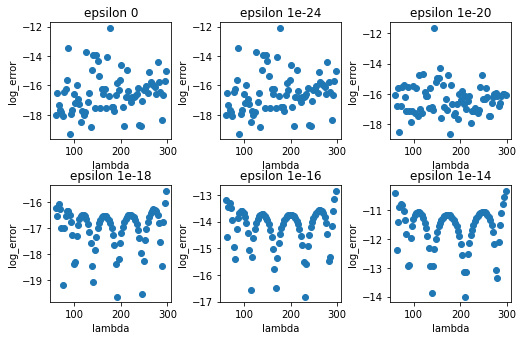

In [178]:
xx = np.arange(60, 300, 240/80)

log_error_0 = log_error_L_test(action_matrix(101), 100, 80, 60, 300, 0, None, None, False)
log_error_m24 = log_error_L_test(action_matrix(101), 100, 80, 60, 300, 1e-24, None, None, False)
log_error_m20 = log_error_L_test(action_matrix(101), 100, 80, 60, 300, 1e-20, None, None, False)
log_error_m18 = log_error_L_test(action_matrix(101), 100, 80, 60, 300, 1e-18, None, None, False)
log_error_m16 = log_error_L_test(action_matrix(101), 100, 80, 60, 300, 1e-16, None, None, False)
log_error_m14 = log_error_L_test(action_matrix(101), 100, 80, 60, 300, 1e-14, None, None, False)

fig, axs = plt.subplots(2, 3)
axs[0, 0].scatter(xx, log_error_0)
axs[0, 0].set_title('epsilon 0')
axs[0, 1].scatter(xx, log_error_m24)
axs[0, 1].set_title('epsilon 1e-24')
axs[0, 2].scatter(xx, log_error_m20)
axs[0, 2].set_title('epsilon 1e-20')
axs[1, 0].scatter(xx, log_error_m18)
axs[1, 0].set_title('epsilon 1e-18')
axs[1, 1].scatter(xx, log_error_m16)
axs[1, 1].set_title('epsilon 1e-16')
axs[1, 2].scatter(xx, log_error_m14)
axs[1, 2].set_title('epsilon 1e-14')

for ax in axs.flat:
    ax.set(xlabel='lambda', ylabel='log_error')

plt.subplots_adjust(left=0.1,
                    bottom=0.03, 
                    right=0.9, 
                    top=1.0, 
                    wspace=0.4, 
                    hspace=0.4)

I would say for the lowener's framework, it has the similar result as projection framework. But for smaller $\epsilon$ 
it works better.

# 3.2 Noise data(Lowener's Framework)

# 3.2.1 comparing noise data and no noise data

$\epsilon = 1e-20$

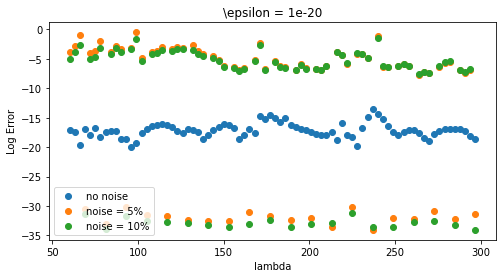

In [19]:
xxc = np.arange(60, 300, 240/80)

noise_vector_1 = vector_d(action_matrix(101), 60, 60, 300)
noise_vector_2 = vector_d(action_matrix(101), 60, 60, 300)


for i in range(60):
             s = np.random.uniform(-1,0,1)
             noise_vector_1[i] = noise_vector_1[i] * (1 + 0.05 * s)
             noise_vector_2[i] = noise_vector_2[i] * (1 + 0.1 * s)


         


log_error_0 = log_error_L_test(action_matrix(101), 60, 80, 60, 300, 1e-20, None, None, False)
log_error_noi05 = log_error_L_test(action_matrix(101), 60, 80, 60, 300, 1e-20, None, noise_vector_1, True)
log_error_noi1 = log_error_L_test(action_matrix(101), 60, 80, 60, 300, 1e-20, None, noise_vector_2, True)


plt.scatter(xxc, log_error_0, label = 'no noise')
plt.scatter(xxc, log_error_noi05, label = 'noise = 5%')
plt.scatter(xxc, log_error_noi1, label = 'noise = 10%')
plt.xlabel("lambda")
plt.ylabel("Log Error")
plt.title("\epsilon = 1e-20")
plt.legend()
plt.show()

# 3.2.2 k = 60, noise level 0.05, different epsilon.

$\epsilon = 0, 1e-20, 1e-16, 1e-12$, $1e-8$, $1e-6$ <br>

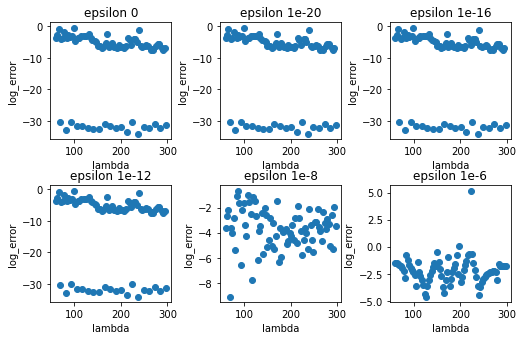

In [20]:
xx = np.arange(60, 300, 240/80)

log_error_0 = log_error_L_test(action_matrix(101), 60, 80, 60, 300, 0, None, noise_vector_1, True)
log_error_m24 = log_error_L_test(action_matrix(101), 60, 80, 60, 300, 1e-20, None, noise_vector_1, True)
log_error_m20 = log_error_L_test(action_matrix(101), 60, 80, 60, 300, 1e-16, None, noise_vector_1, True)
log_error_m18 = log_error_L_test(action_matrix(101), 60, 80, 60, 300, 1e-12, None, noise_vector_1, True)
log_error_m16 = log_error_L_test(action_matrix(101), 60, 80, 60, 300, 1e-8, None, noise_vector_1, True)
log_error_m10 = log_error_L_test(action_matrix(101), 60, 80, 60, 300, 1e-6, None, noise_vector_1, True)

fig, axs = plt.subplots(2, 3)
axs[0, 0].scatter(xx, log_error_0)
axs[0, 0].set_title('epsilon 0')
axs[0, 1].scatter(xx, log_error_m24)
axs[0, 1].set_title('epsilon 1e-20')
axs[0, 2].scatter(xx, log_error_m20)
axs[0, 2].set_title('epsilon 1e-16')
axs[1, 0].scatter(xx, log_error_m18)
axs[1, 0].set_title('epsilon 1e-12')
axs[1, 1].scatter(xx, log_error_m16)
axs[1, 1].set_title('epsilon 1e-8')
axs[1, 2].scatter(xx, log_error_m10)
axs[1, 2].set_title('epsilon 1e-6')



for ax in axs.flat:
    ax.set(xlabel='lambda', ylabel='log_error')

plt.subplots_adjust(left=0.1,
                    bottom=0.03, 
                    right=0.9, 
                    top=1.0, 
                    wspace=0.4, 
                    hspace=0.4)

# 3.2.3 k = 60, noise level 0.1, different epsilon.

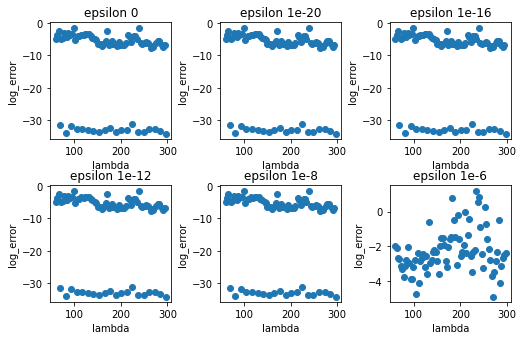

In [26]:
xx = np.arange(60, 300, 240/80)

log_error_0 = log_error_L_test(action_matrix(101), 60, 80, 60, 300, 0, None, noise_vector_2, True)
log_error_m24 = log_error_L_test(action_matrix(101), 60, 80, 60, 300, 1e-20, None, noise_vector_2, True)
log_error_m20 = log_error_L_test(action_matrix(101), 60, 80, 60, 300, 1e-16, None, noise_vector_2, True)
log_error_m18 = log_error_L_test(action_matrix(101), 60, 80, 60, 300, 1e-12, None, noise_vector_2, True)
log_error_m16 = log_error_L_test(action_matrix(101), 60, 80, 60, 300, 1e-8, None, noise_vector_2, True)
log_error_m10 = log_error_L_test(action_matrix(101), 60, 80, 60, 300, 1e-6, None, noise_vector_2, True)

fig, axs = plt.subplots(2, 3)
axs[0, 0].scatter(xx, log_error_0)
axs[0, 0].set_title('epsilon 0')
axs[0, 1].scatter(xx, log_error_m24)
axs[0, 1].set_title('epsilon 1e-20')
axs[0, 2].scatter(xx, log_error_m20)
axs[0, 2].set_title('epsilon 1e-16')
axs[1, 0].scatter(xx, log_error_m18)
axs[1, 0].set_title('epsilon 1e-12')
axs[1, 1].scatter(xx, log_error_m16)
axs[1, 1].set_title('epsilon 1e-8')
axs[1, 2].scatter(xx, log_error_m10)
axs[1, 2].set_title('epsilon 1e-6')



for ax in axs.flat:
    ax.set(xlabel='lambda', ylabel='log_error')

plt.subplots_adjust(left=0.1,
                    bottom=0.03, 
                    right=0.9, 
                    top=1.0, 
                    wspace=0.4, 
                    hspace=0.4)

For lowner's Framework, the best $\epsilon = 1e-20$. It means that truncating more vectors can not give us better result